So this is a Email Sorting Assistant ***(with mail generator - which I integrated later on)*** built with LangGraph and Gemini (not using openAI here since it needs money 💵)

In [1]:
!pip install -q langgraph langchain-google-genai google-generativeai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.2/145.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.9/433.9 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 11.6 MB/s eta 0:00:00


In [2]:
import os 
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage

In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
gemini_api = user_secrets.get_secret("GOOGLE_API_KEY")

In [4]:
os.environ["GOOGLE_API_KEY"] = gemini_api

In [5]:
model = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0.3)

In [6]:
class EmailState(TypedDict):
    email: Dict[str, Any]
    is_spam: Optional[bool]
    email_category: Optional[str]
    priority: Optional[str]
    draft_response: Optional[str]
    messages: List[Dict[str, Any]]

In [19]:
##@ Defining the nodes

def read_mail(state: EmailState):
    """This is the FirstNode: Log that we are processing the email"""
    email = state["email"]
    print(f"Processing an email from {email['sender']} with subject: {email['subject']}")
    return{}

def analyze_mail(state: EmailState):
    """Second Node: Analyses the email for spam, category and priority"""
    email = state["email"]

    prompt= f"""
    Analyze the email and determine:
    - if the email is spam or not (yes/no)
    - which category the mail falls under (work, personal, finance, education etc.)
    - the category of the mail (high, medium, low)

    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}

    Format your respose  as:
    SPAM: [yes/ no]
    CATEGORY: [Category]
    PRIORITY: [Priority]
    """

    messages = [HumanMessage(content = prompt)]

    try:
        response = model.invoke(messages)
        response_text = response.content
        print(f"Analysis Result: \n{response_text}")

        #@ Parsing the response
        lines = response_text.strip().split('\n')
        is_spam = 'yes' in lines[0].lower() if lines and 'spam' in lines[0].lower() else False

        #@ Extract category and priority if available
        email_category = lines[1].split(':')[1].strip() if len(lines) > 1 and ':' in lines[1] else "Uncategorized"
        priority = lines[2].split(':')[1].strip() if len(lines) > 2 and ':' in lines[2] else "Medium"

    except Exception as e:
        print(f"Model Error {str(e)}")
        #@ falling back with basic detection
        is_spam = any(word in email['subject'].lower() for word in ['crypto', 'investment', 'free', 'billion', 'millionare', 'billionare', 'million', 'urgent', 'bitcoin', 'offer'])
        email_category = "Uncategorized"
        priority = "Medium"
        print(f"Fallback sys analysis: SPAM: {'YES' if is_spam else 'NO'}, CATEGORY: {email_category}, PRIORITY: {priority}")

    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt}, 
        {"role": "assistant", "content": response_text if 'response_text' in locals() else "Analysis not available"}
    ]

    return {
        "is_spam": is_spam, 
        "email_category": email_category, 
        "priority": priority, 
        "messages": new_messages
    }

def handle_spam(state: EmailState):
    """Another node: Handles all spam Emails"""
    print(f"📩 The email has been marked as spam.")
    print("🗑️ The email has been moved to the spam folder.")
    return {}

def categorize_mail(state: EmailState):
    """Node: Organizes all the mails based on category and priority"""
    print(f"📂 Email categorized as: {state['email_category']}")
    print(f"🔔 Priority level: {state['priority']}")
    return {}

def drafting_response(state: EmailState):
    """Draft a response for non-spam emails"""
    email = state["email"]
    category = state["email_category"]
    priority = state["priority"]

    prompt = f"""
    Draft a polite response to this email.

    Email details:
    - From: {email['sender']}
    - Subject: {email['subject']}
    - Body: {email['body']}
    - Category: {category}
    - Priority: {priority}

    Draft a concise, professional response. If it's a high priority email, show more urgency in your response.
    """
    messages = [HumanMessage(content=prompt)]

    try:
        response = model.invoke(messages)
        draft_response = response.content
    except Exception as e:
        print(f"Model error while drafting: {str(e)}")
        # Fallback simple template
        draft_response = f"""Dear {email['sender']},

        Thank you for your email regarding '{email['subject']}'. 
        
        I've received your message and will address it {priority.lower() == 'high' and 'as soon as possible' or 'in due course'}.
        
        Best regards,
        Your Name"""
            
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": draft_response}
    ]

    return {
        "draft_response": draft_response,
        "messages": new_messages
    }

def notify_user(state: EmailState):
    """Final node: Present the email and draft response to the user"""
    email = state["email"]
    category = state["email_category"]
    priority = state["priority"]

    priority_emoji = "🔴" if priority.lower() == "high" else "🟡" if priority.lower() == "medium" else "🟢"

    print("\n" + "="*60)
    print(f"{priority_emoji} {priority} Priority | {category} Email")
    print(f"From: {email['sender']}")
    print(f"Subject: {email['subject']}")
    print("-"*60)
    print("Draft response:")
    print(state["draft_response"])
    print("="*60 + "\n")

    return {}

In [20]:
##@ Defining the routing logic:
def route_mail (state: EmailState) -> str:
    if state['is_spam']:
        return "spam"
    else:
        return "legitimate"

In [21]:
#@ Creating the graph:
email_graph = StateGraph(EmailState)


##@ Adding Nodes 
email_graph.add_node("read_mail", read_mail)
email_graph.add_node("analyze_mail", analyze_mail)
email_graph.add_node("handle_spam", handle_spam)
email_graph.add_node("categorize_mail", categorize_mail)
email_graph.add_node("drafting_response", drafting_response)
email_graph.add_node("notify_user", notify_user)

#@ Adding edges 
email_graph.add_edge(START, "read_mail")
email_graph.add_edge("read_mail", "analyze_mail")

#@ Conditional Edges
email_graph.add_conditional_edges(
    "analyze_mail", 
    route_mail, 
    {
        "spam": "handle_spam", 
        "legitimate": "categorize_mail"
    }
)

##@ Adding remaining edges
email_graph.add_edge("handle_spam", END)
email_graph.add_edge("categorize_mail", "drafting_response")
email_graph.add_edge("drafting_response", "notify_user")
email_graph.add_edge("notify_user", END)

##@ Compile the graph
compiled_graph = email_graph.compile()

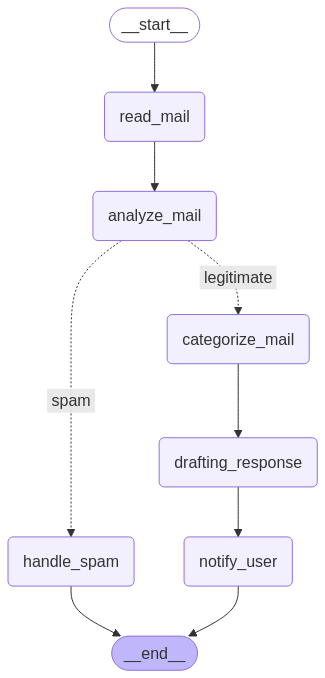

In [22]:
from IPython.display import Image, display
display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [34]:
##@ Example Mails for testing 

legitimate_mail = {
    "sender": "ramhari01@yahoo.com", 
    "subject": "Fellowship update - Projects Assigned", 
    "body": "Hello Fellow_05, \n\n Our team has assigned fellowship project to your team. \n Please visit Slack for more details. \n\n Best regards, \n Sam Nazi"
}

urgent_mail = {
    "sender": "boss@company.com",
    "subject": "URGENT: Meeting with clients today",
    "body": "We have an unexpected meeting with our key clients in 2 hours. Please prepare the latest project metrics and join us in the conference room at 3 PM. This is a high priority."
}

spam_mail = {
    "sender": "lucky.winner@freemoney.biz",
    "subject": "You've WON $5,000,000!!!",
    "body": "CONGRATULATIONS! You've been selected as the winner of our lottery draw. To claim your $5,000,000 prize, please send us your bank details and a small processing fee of $100."
}

random_mail_1 = {
  "sender": "sam@crypto_global_agency.com",
  "subject": "Important: BTC Reward for Your Participation in Our New Initiative",
  "body": "Hello Palpating_heart09,\n\nI hope this email finds you well.\n\nI’m reaching out on behalf of Crypto Global Agency to inform you about a new initiative we are rolling out. As part of this project, we are offering a BTC reward to individuals who choose to participate in a small-scale program designed to support blockchain education and adoption.\n\nHere’s how it works:\n- **BTC Reward**: Upon completing the initial registration and verification, you will receive a reward of 0.015 BTC.\n- **How to Participate**: Simply visit the secure project page and complete the steps outlined there. You can also connect with our team via Slack for any assistance.\n\nIf you’re interested, please reply to this email or visit the program page linked below. All instructions are clear, and we ensure that the process is fully transparent.\n\nBest regards,\nSam Nazi\nProgram Manager\nCrypto Global Agency\n[Website Link or Program Details]"
}

random_mail_2 = {
  "sender": "finance@globalinvestmentfirm.com",
  "subject": "Update: New Investment Opportunity – Your Portfolio",
  "body": "Hello Palpating_heart09,\n\nWe hope you're doing well.\n\nWe wanted to update you on an exciting new investment opportunity available through Global Investment Firm. Based on your recent portfolio activities, we believe this initiative could align well with your financial goals.\n\nThe investment option involves low-risk blockchain technology investments with potential for long-term growth. If you're interested, please review the details through your account portal or schedule a quick call with our financial advisor team to learn more.\n\nWe’d be happy to discuss this with you at your earliest convenience.\n\nBest regards,\nJohn Doe\nClient Relations Manager\nGlobal Investment Firm"
}

random_mail_3 = {
  "sender": "prof.johnson@university.edu",
  "subject": "Reminder: Upcoming Webinar on Career Development – Optional",
  "body": "Dear Student,\n\nI hope this message finds you well.\n\nThis is a reminder that our upcoming career development webinar will be taking place next week on Tuesday at 4 PM. While attendance is optional, it’s a great opportunity for students looking to gain insights on job applications, internships, and interview strategies.\n\nFeel free to join us if you’re interested. The session will be hosted virtually, and you can register using the link provided in the university portal.\n\nIf you have any questions, please don’t hesitate to reach out.\n\nBest regards,\nProfessor Johnson\nDepartment of Career Services\nUniversity of [Your University]"
}

In [24]:
print("\nProcessing legitimate work email...")
legitimate_result = compiled_graph.invoke({
    "email": legitimate_mail,
    "is_spam": None,
    "email_category": None,
    "priority": None,
    "draft_response": None,
    "messages": []
})


Processing legitimate work email...
Processing an email from ramhari01@yahoo.com with subject: Fellowship update - Projects Assigned
Analysis Result: 
SPAM: no
CATEGORY: work
PRIORITY: high
📂 Email categorized as: work
🔔 Priority level: high

🔴 high Priority | work Email
From: ramhari01@yahoo.com
Subject: Fellowship update - Projects Assigned
------------------------------------------------------------
Draft response:
Subject: Re: Fellowship update - Projects Assigned

Dear Sam,

Thank you for the update.  I will check Slack immediately for details on the assigned fellowship project.

Regards,

Fellow_05



In [26]:
print("\nProcessing urgent email...")
urgent_result = compiled_graph.invoke({
    "email": urgent_mail,
    "is_spam": None,
    "email_category": None,
    "priority": None,
    "draft_response": None,
    "messages": []
})


Processing urgent email...
Processing an email from boss@company.com with subject: URGENT: Meeting with clients today
Analysis Result: 
SPAM: no
CATEGORY: work
PRIORITY: high
📂 Email categorized as: work
🔔 Priority level: high

🔴 high Priority | work Email
From: boss@company.com
Subject: URGENT: Meeting with clients today
------------------------------------------------------------
Draft response:
Subject: Re: URGENT: Meeting with clients today

Understood. I'm compiling the latest project metrics now and will be in the conference room by 3 PM.



In [29]:
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke({
    "email": spam_mail,
    "is_spam": None,
    "email_category": None,
    "priority": None,
    "draft_response": None,
    "messages": []
})


Processing spam email...
Processing an email from lucky.winner@freemoney.biz with subject: You've WON $5,000,000!!!
Analysis Result: 
SPAM: yes
CATEGORY: Finance
PRIORITY: Low
📩 The email has been marked as spam.
🗑️ The email has been moved to the spam folder.


In [33]:
print("\nProcessing random email...")
legitimate_result = compiled_graph.invoke({
    "email": random_mail_1,
    "is_spam": None,
    "email_category": None,
    "priority": None,
    "draft_response": None,
    "messages": []
})


Processing random email...
Processing an email from sam@crypto_global_agency.com with subject: Important: BTC Reward for Your Participation in Our New Initiative
Analysis Result: 
SPAM: yes
CATEGORY: Finance
PRIORITY: Low
📩 The email has been marked as spam.
🗑️ The email has been moved to the spam folder.


In [35]:
print("\nProcessing random email...")
legitimate_result = compiled_graph.invoke({
    "email": random_mail_2,
    "is_spam": None,
    "email_category": None,
    "priority": None,
    "draft_response": None,
    "messages": []
})


Processing random email...
Processing an email from finance@globalinvestmentfirm.com with subject: Update: New Investment Opportunity – Your Portfolio
Analysis Result: 
SPAM: no
CATEGORY: Finance
PRIORITY: Medium
📂 Email categorized as: Finance
🔔 Priority level: Medium

🟡 Medium Priority | Finance Email
From: finance@globalinvestmentfirm.com
Subject: Update: New Investment Opportunity – Your Portfolio
------------------------------------------------------------
Draft response:
Subject: Re: Update: New Investment Opportunity – Your Portfolio

Dear Mr. Doe,

Thank you for reaching out and informing me about this new investment opportunity.  I will review the details through my account portal at my earliest convenience.

Sincerely,

Palpating_heart09



In [36]:
print("\nProcessing random email...")
legitimate_result = compiled_graph.invoke({
    "email": random_mail_3,
    "is_spam": None,
    "email_category": None,
    "priority": None,
    "draft_response": None,
    "messages": []
})


Processing random email...
Processing an email from prof.johnson@university.edu with subject: Reminder: Upcoming Webinar on Career Development – Optional
Analysis Result: 
SPAM: no
CATEGORY: Education
PRIORITY: Medium
📂 Email categorized as: Education
🔔 Priority level: Medium

🟡 Medium Priority | Education Email
From: prof.johnson@university.edu
Subject: Reminder: Upcoming Webinar on Career Development – Optional
------------------------------------------------------------
Draft response:
Subject: Re: Reminder: Upcoming Webinar on Career Development – Optional

Dear Professor Johnson,

Thank you for the reminder about the career development webinar. I will check my university portal for the registration link and plan to attend if my schedule allows.

Sincerely,

[Your Name]
[Your Student ID Number (optional)]



And Project is done. I guess !! 
